# Hourly Energy Consumption Forecast (Part 2/2)

## 1. Hourly Time Series Forecasting using XGBOOST

### 1.1. Data pre-processing


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('ggplot')

In [2]:
import os

In [3]:
os.getcwd()

'C:\\Users\\Ingrid - CITCEA\\Documents\\Ironhack_Data_Science_Workshop\\Ironhack_Data_Science_Workshop2019\\Energy_forecast'

In [4]:
pjme = pd.read_csv('./hourly-energy-consumption/PJME_hourly.csv', index_col=[0], parse_dates = [0] )

In [5]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


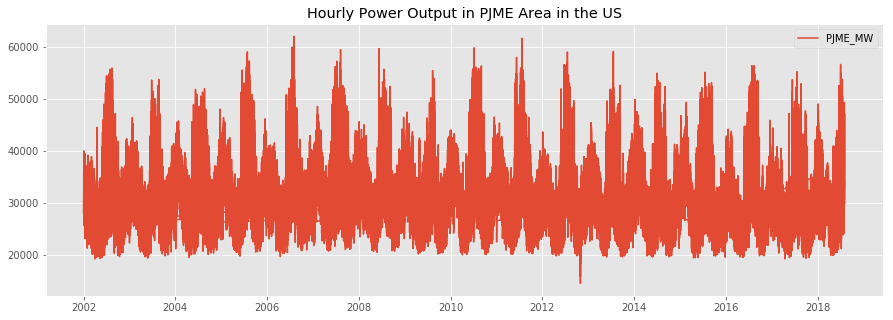

In [6]:
plt.figure(figsize=(15,5))
plt.plot(pjme, label='PJME_MW')
plt.title('Hourly Power Output in PJME Area in the US')
plt.legend()
plt.show()

### 1.2 Train/Test Split

We will use years 2002-2005 as our train set (as we did with Prophet FB library, and 2015 onwards as our validation or test set.

In [7]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()

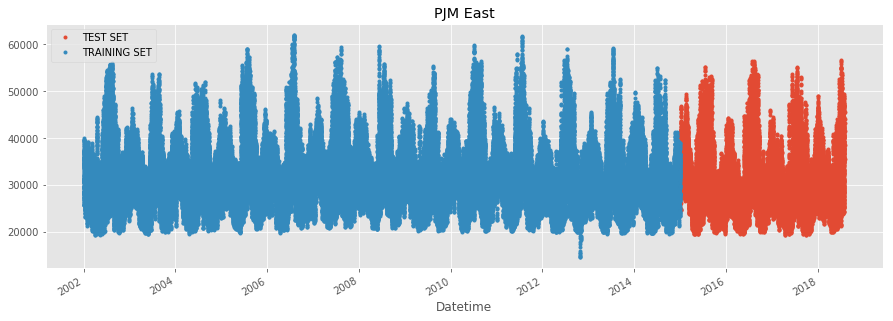

In [8]:
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

### 1.3 Create T-S features for the model

We will create different features from the Time series data we have. We will include in our model: 

- index
- hour
- day of week
- quarter
- month
- year
- day of year
- day
- week of year 


In [9]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [10]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

In [11]:
X_train.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1


### 1.3 Create XGBoost model

In [12]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=True) # Change verbose to True if you want to see it train

[17:46:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29710.4	validation_1-rmse:28762.5
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.


F:\Programs\envs\data-science\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
F:\Programs\envs\data-science\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[1]	validation_0-rmse:26822.6	validation_1-rmse:25892.2
[2]	validation_0-rmse:24211.2	validation_1-rmse:23286.6
[3]	validation_0-rmse:21885	validation_1-rmse:20967.5
[4]	validation_0-rmse:19780.3	validation_1-rmse:18868.5
[5]	validation_0-rmse:17910	validation_1-rmse:17017.7
[6]	validation_0-rmse:16216.1	validation_1-rmse:15336.4
[7]	validation_0-rmse:14717.8	validation_1-rmse:13861.5
[8]	validation_0-rmse:13377.4	validation_1-rmse:12536.3
[9]	validation_0-rmse:12184.1	validation_1-rmse:11362.1
[10]	validation_0-rmse:11099.4	validation_1-rmse:10298.7
[11]	validation_0-rmse:10135.2	validation_1-rmse:9357.58
[12]	validation_0-rmse:9294.73	validation_1-rmse:8555.98
[13]	validation_0-rmse:8552.87	validation_1-rmse:7853.17
[14]	validation_0-rmse:7874.91	validation_1-rmse:7207.84
[15]	validation_0-rmse:7276.11	validation_1-rmse:6651.82
[16]	validation_0-rmse:6747	validation_1-rmse:6171.82
[17]	validation_0-rmse:6299.44	validation_1-rmse:5774.19
[18]	validation_0-rmse:5910.49	validation_1-rms

[145]	validation_0-rmse:2932.23	validation_1-rmse:3716.29
[146]	validation_0-rmse:2931.2	validation_1-rmse:3717.22
[147]	validation_0-rmse:2930.35	validation_1-rmse:3718.02
[148]	validation_0-rmse:2928.75	validation_1-rmse:3717.76
[149]	validation_0-rmse:2923.14	validation_1-rmse:3712.2
[150]	validation_0-rmse:2920.09	validation_1-rmse:3714.78
[151]	validation_0-rmse:2919.09	validation_1-rmse:3714.25
[152]	validation_0-rmse:2918.28	validation_1-rmse:3713.52
[153]	validation_0-rmse:2917.79	validation_1-rmse:3713.66
[154]	validation_0-rmse:2917.19	validation_1-rmse:3714.73
[155]	validation_0-rmse:2916.37	validation_1-rmse:3714.26
[156]	validation_0-rmse:2915.65	validation_1-rmse:3716.12
[157]	validation_0-rmse:2915.18	validation_1-rmse:3716.75
[158]	validation_0-rmse:2910.8	validation_1-rmse:3718.45
[159]	validation_0-rmse:2908.21	validation_1-rmse:3716.42
[160]	validation_0-rmse:2905.92	validation_1-rmse:3716.91
[161]	validation_0-rmse:2902.12	validation_1-rmse:3730.8
[162]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

### *Ranking the features' importance*

A good idea to see which are the features that the model is relying on the most to predict is by measuring their importance in the model. In XGBOOST this can be easily done by ploting the importance, which is considered by a metric that simply sums up how many times each feature is split on

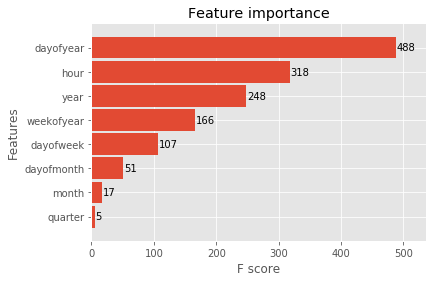

In [13]:
plot_importance(reg, height= 0.9)



### 1.4 Forecasting on test set

In [14]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

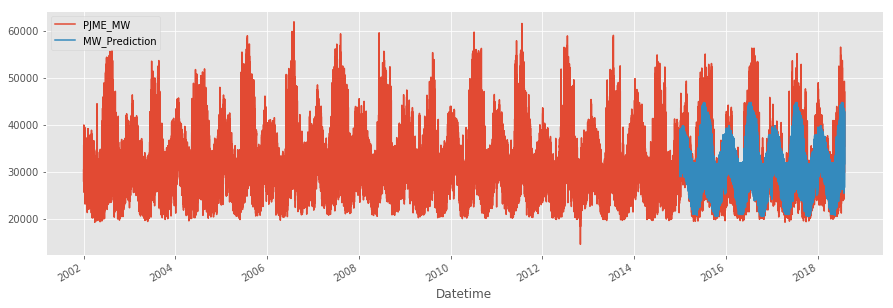

In [15]:
pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

### 1.4.1 Taking a look at first month of predictions

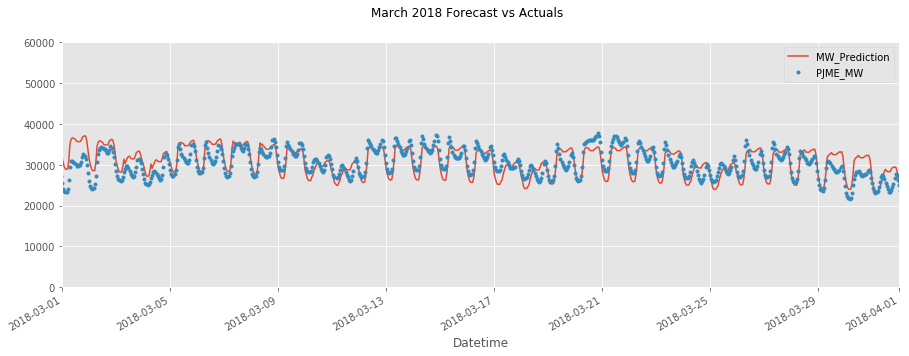

In [16]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='03-01-2018', upper='04-01-2018')
ax.set_ylim(0, 60000)
plot = plt.suptitle('March 2018 Forecast vs Actuals')

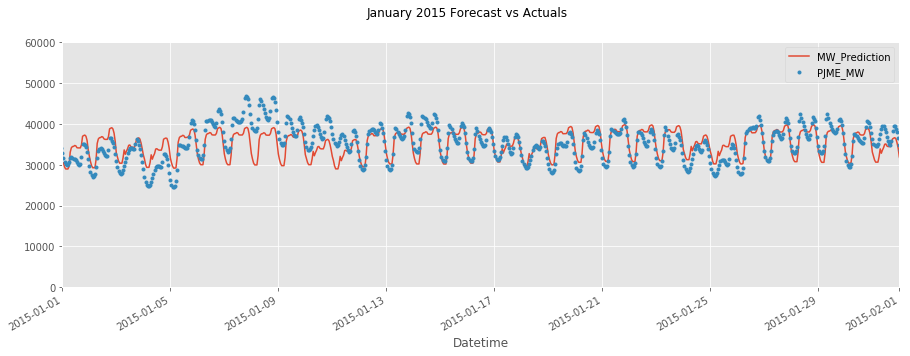

In [17]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')

### First week of January

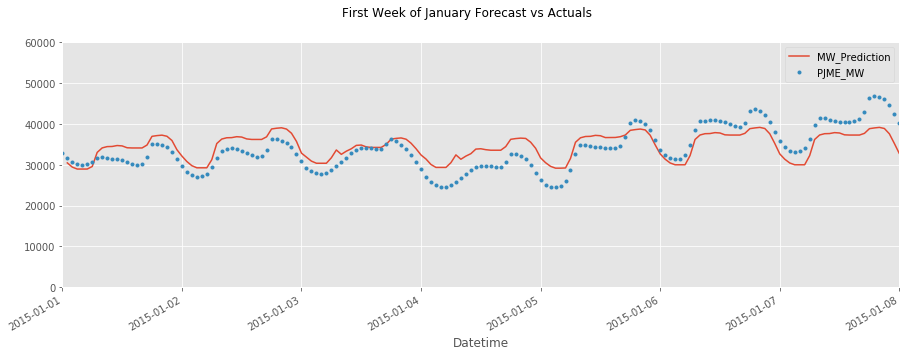

In [18]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')

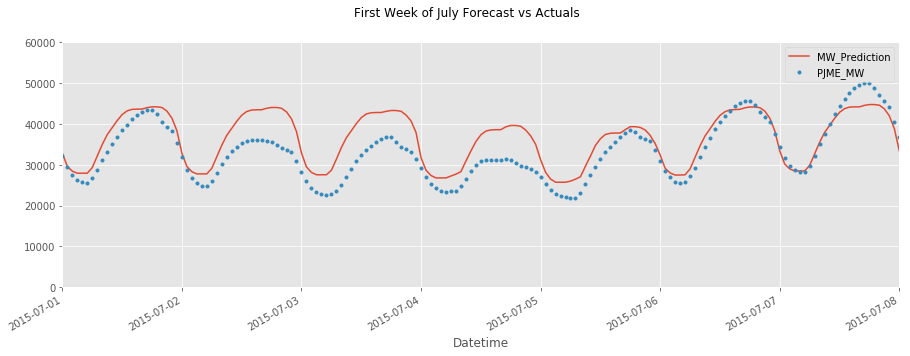

In [19]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

### Error Metrics On Test Set

In [20]:
mean_squared_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

13780445.55710396

In [21]:
mean_absolute_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

2848.891429322955

In [22]:


def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



In [23]:
mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                   y_pred=pjme_test['MW_Prediction'])

8.94944673745318

### Look at Worst and Best Predicted Days

In [24]:
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [25]:


# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)



PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   36986.964844 -8587.006429  8587.006429
2017 2     24          26445.083333   33814.503906 -7369.422445  7369.422445
2015 12    25          24466.083333   31584.923828 -7118.841390  7118.841390
2017 2     20          27070.583333   34100.781250 -7030.197754  7030.197754
2015 7     3           30024.875000   37021.031250 -6996.156169  6996.156169
2017 6     28          30531.208333   37526.589844 -6995.380371  6995.380371
     2     8           28523.833333   35511.699219 -6987.864258  6987.864258
     9     2           24201.458333   31180.390625 -6978.933105  6978.933105
     2     25          24344.458333   31284.279297 -6939.820150  6939.820150
2018 2     21          27572.500000   34477.417969 -6904.919352  6904.919352



Notice anything about the over forecasted days?

    #1 worst day - July 4th, 2016 - is a holiday.
    #3 worst day - December 25, 2015 - Christmas
    #5 worst day - July 4th, 2016 - is a holiday.
    Looks like our model may benefit from adding a holiday indicator.



In [26]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31753.224609  13432.608887  13432.608887
           14          44427.333333   31058.818359  13368.514404  13368.514404
     9     10          40996.166667   29786.179688  11209.987793  11209.987793
           9           43836.958333   32831.035156  11005.923828  11005.923828
2015 2     20          44694.041667   33814.503906  10879.535889  10879.535889
2018 1     6           43565.750000   33435.265625  10130.485921  10130.485921
2016 8     12          45724.708333   35609.312500  10115.394287  10115.394287
2017 5     19          38032.583333   28108.976562   9923.606689   9923.606689
     12    31          39016.000000   29314.683594   9701.315430   9701.315430
2015 2     21          40918.666667   31284.279297   9634.388184   9634.388184



The best predicted days seem to be a lot of october (not many holidays and mild weather) Also early may


In [27]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)



PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 10    3           27705.583333   27775.351562  -69.768148  229.585205
2015 10    28          28500.958333   28160.875000  340.083740  388.023356
2016 10    8           25183.333333   25535.669922 -352.337402  401.017090
     5     1           24503.625000   24795.419922 -291.794515  428.289307
2017 10    29          24605.666667   24776.271484 -170.605225  474.628988
2016 9     16          29258.500000   29397.271484 -138.770833  491.070312
     3     20          27989.416667   27620.132812  369.284831  499.750488
     10    2           24659.083333   25134.919922 -475.836670  516.188232
2017 10    14          24949.583333   25399.728516 -450.145996  520.855794
2015 5     6           28948.666667   28710.271484  238.396077  546.640544

### Plotting some best/worst predicted days

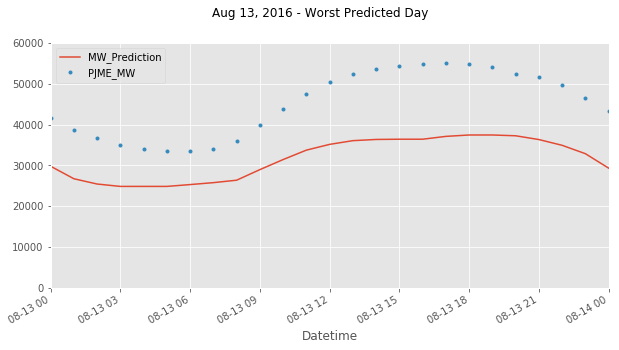

In [28]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='08-13-2016', upper='08-14-2016')
plot = plt.suptitle('Aug 13, 2016 - Worst Predicted Day')

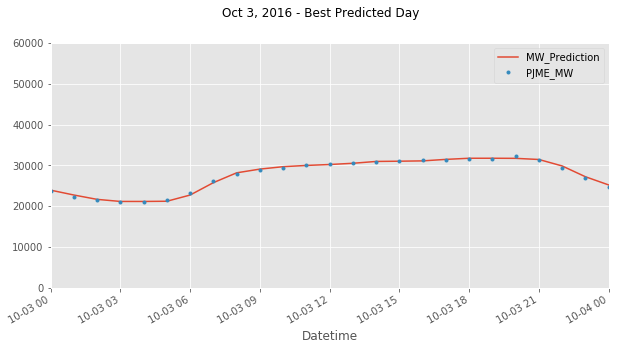

In [29]:


f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = pjme_all[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='10-03-2016', upper='10-04-2016')
plot = plt.suptitle('Oct 3, 2016 - Best Predicted Day')




Up next?

    Add Lag variables
    Add holiday indicators.
    Add weather data source.



### Predicting further dates

In [32]:
pjme_test.tail()

,PJME_MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,MW_Prediction,error,abs_error
Datetime,,,,,,,,,,,,,
2018-01-01 20:00:00,44284.0,2018-01-01 20:00:00,20,0,1,1,2018,1,1,1,36243.679688,8040.320312,8040.320312
2018-01-01 21:00:00,43751.0,2018-01-01 21:00:00,21,0,1,1,2018,1,1,1,36019.375000,7731.625000,7731.625000
2018-01-01 22:00:00,42402.0,2018-01-01 22:00:00,22,0,1,1,2018,1,1,1,34988.699219,7413.300781,7413.300781
2018-01-01 23:00:00,40164.0,2018-01-01 23:00:00,23,0,1,1,2018,1,1,1,32725.597656,7438.402344,7438.402344
2018-01-02 00:00:00,38608.0,2018-01-02 00:00:00,0,1,1,1,2018,2,2,1,31440.660156,7167.339844,7167.339844


In [33]:
X_test.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2015-12-31 01:00:00,1,3,4,12,2015,365,31,53
2015-12-31 02:00:00,2,3,4,12,2015,365,31,53
2015-12-31 03:00:00,3,3,4,12,2015,365,31,53
2015-12-31 04:00:00,4,3,4,12,2015,365,31,53
2015-12-31 05:00:00,5,3,4,12,2015,365,31,53


In [ ]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [45]:
fcast_2018 = pd.DataFrame(index=pd.date_range(start='1/1/2018 00:00:00', end='1/1/2020 00:00:00', freq= '1H'))

In [46]:
fcast_2018.head()

""
2018-01-01 00:00:00
2018-01-01 01:00:00
2018-01-01 02:00:00
2018-01-01 03:00:00
2018-01-01 04:00:00


In [47]:
fcast_2018_df = create_features(fcast_2018)

In [48]:
fcast_2018_df.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
2018-01-01 00:00:00,0,0,1,1,2018,1,1,1
2018-01-01 01:00:00,1,0,1,1,2018,1,1,1
2018-01-01 02:00:00,2,0,1,1,2018,1,1,1
2018-01-01 03:00:00,3,0,1,1,2018,1,1,1
2018-01-01 04:00:00,4,0,1,1,2018,1,1,1


In [49]:
pjme_2018 = fcast_2018_df.copy()

In [50]:
pjme_2018['MW_Prediction'] = reg.predict(fcast_2018_df)
pjme_all_future = pd.concat([pjme_2018, pjme_test, pjme_train], sort=False)

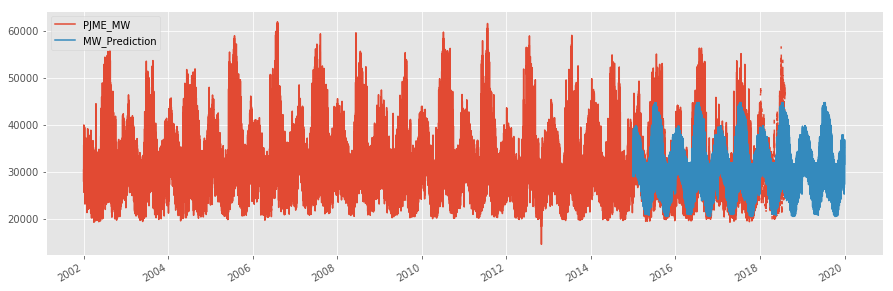

In [51]:
pjme_all_future[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

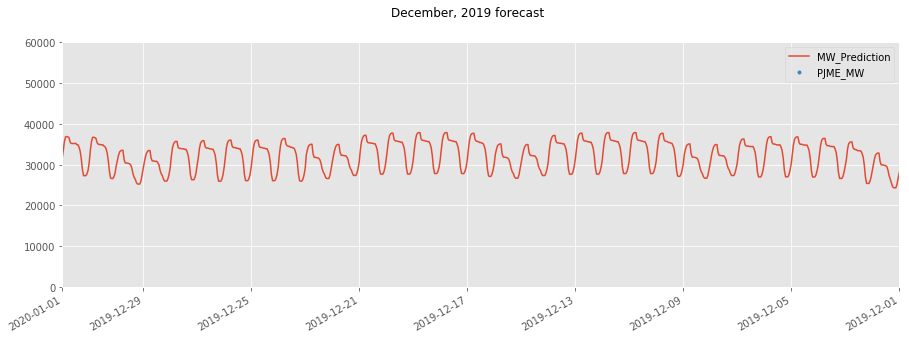

In [58]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = pjme_all_future[['MW_Prediction','PJME_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='12-01-2019', upper='01-01-2020')
ax.set_ylim(0, 60000)
plot = plt.suptitle('December, 2019 forecast')